In [2]:
#!pip3 install torchvision==0.12.0
#!pip3 install torch==1.11.0
#!pip3 install torchtext==0.12.0
#!python3 -m spacy download en_core_web_sm

In [17]:
import torch.nn as nn
import torchvision.models as models
import torch
import torchvision

import os
import pandas
import spacy
import torchtext

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from torchvision.transforms import transforms

# python3 -m spacy download en_core_web_sm

print(torch.__version__, torchtext.__version__, spacy.__version__)

spacy_eng = spacy.load("en_core_web_sm")


1.11.0 0.12.0 3.3.1


In [18]:

class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}
        
        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (frequency[word] > self.freq_threshold-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]
                    
        
annotation = pandas.read_csv("./flickr8k/captions.txt")


In [19]:

class FlickrDataset(Dataset):
    def __init__(self, root_dir="./flickr8k/images", caption_path="./flickr8k/captions.txt", freq_threshold=5, transform=None, data_length=10000):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pandas.read_csv(caption_path)[:data_length]
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        
        self.vocab = Vocabulary(freq_threshold)
        
        print(len(self.captions.tolist()))
        self.vocab.build_vocabulary(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        
        numericalized_caption += self.vocab.numericalize(caption)
        
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_value)
        
        return img, targets


transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

def get_loader(root_dir="./flickr8k/images", caption_path="./flickr8k/captions.txt", transform=transform, batch_size=32, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir,caption_path=caption_path, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]
    
    loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, pin_memory=True, collate_fn=MyCollate(pad_value))
    
    return loader, dataset



In [20]:

loader, dataset = get_loader()



10000


In [21]:
for image, text in loader:
    print(image.shape, text.shape)
    break

torch.Size([32, 3, 299, 299]) torch.Size([22, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([     1, 108867, 107374,  95775,      2])


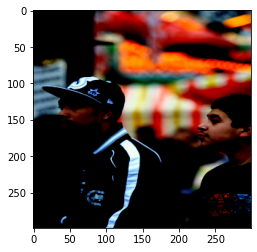

In [22]:

import random
import math

x, y = dataset[math.floor(random.random() * len(dataset))]
x.shape, y.shape


import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))
print(y)

# print(dataset.vocab.itos[1])


In [23]:

for i in y:
    print(dataset.vocab.itos[int(i)],end=" ")


def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
    print("saving checkpoint!")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("loading checkpoint!")
    model.load_state_dict(checkpoint["state_dict"])
    model.load_state_optimizer(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

from tqdm import tqdm

torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
load_model = False
save_model = False
train_CNN = False

<SOS> two male spectators <EOS> 

In [24]:
import torch.optim as optim 

step = 0
embed_size = 256
hidden_size = 256
num_layers = 5
num_epochs = 5
learning_rate = 3e-4
vocab_size = len(dataset.vocab)

In [25]:
new_model = models.inception_v3(pretrained=True, aux_logits=False)
new_model.fc

Linear(in_features=2048, out_features=1000, bias=True)

# Encoder

In [134]:
class Encoder(nn.Module):
    
    def __init__(self,encoded_image_size=14,fine_tune=True):
        super(Encoder,self).__init__()
        self.enc_size = encoded_image_size
        resnet = torchvision.models.resnet101(pretrained=True)
#         We remove the linear and pool layers at the end since we are not doing classification
        modules = list(resnet.children())[:-2]
        self.model = nn.Sequential(*modules)
        self.pool = nn.AdaptiveAvgPool2d(self.enc_size)
        
        #self.fine_tune(fine_tune)
    
    def forward(self,x):
        bp = self.model(x) # (batch,2048,img/32,img/32)
        ap = self.pool(bp) # (batch, 2048,enc_img_size,enc_img_size)
        out = ap.permute(0,2,3,1) #(batch,enc_img_size,enc_img_size,2048)

        print(x.shape, bp.shape, ap.shape, out.shape)

        return out

In [135]:
# enc = Encoder(14)
# img, text = next(iter(loader))
# img.shape, text.shape

# encoded_image = enc(img)

In [136]:
# encoded_image.shape

# Attention layer

### the goal of the attention is to encode the information about the image pixels in every step of the decoder

#### lstm_out, (hidden, cell) = LSTM(weighted_attention_pixel, current_word, decoder_hidden, cell)

the implementation will have seq_len steps instead of having just one step !!! 

weighted_attention_vector = alpha * (batch x number of pixels) = batch x number of pixels

1) decoder_hidden -> batch x 1 x hid_dim -> batch x 1 x att_dim 
2) image features -> batch x nb_pixels -> batch x nb_pixels x att_dim 
3) compute the relationship between a) current decoder_hidden b) pixel for the image => do a dot product 



In [137]:
class Attention(nn.Module):
    def __init__(self, enc_dim, dec_dim, att_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(enc_dim, att_dim)
        self.decoder_att = nn.Linear(dec_dim, att_dim)
        self.full_att = nn.Linear(att_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoded_image, decoder_hidden):
        # encoded_image = batch_size x pixels(14x14) x 2048 channels => batch_size x 14 x 14 x att_dim
        att1 = self.encoder_att(encoded_image)
        
        # decoder_hidden = batch x dec_dim = batch x 512
        att2 = self.decoder_att(decoder_hidden)

        # att1 = batch x pixels x att_dim; att2 = batch x 1 x att_dim
        # attention_full = batch x pixels x 1 => batch x pixels after squeezing dim=2
        att_full = self.full_att(att1 + att2.unsqueeze(1)).squeeze(2)
        
        # alpha = batch x pixels
        alpha = self.softmax(att_full)

        # alpha = batch x pixels x 1; encoder_out = batch x pixels x enc_dim
        # weighted_attention_vector = batch x ([enc_dim x pixels] x [pixels x 1]) = batch x enc_dim x 1 = [batch x enc_dim] 
        weighted_attention_vector = torch.bmm(encoded_image.permute(0, 2, 1), alpha.unsqueeze(2))

        return weighted_attention_vector, alpha

In [138]:
class Decoder(nn.Module):
    def __init__(self, emb_size, vocab_size, enc_dim, dec_dim, att_dim):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        # https://stackoverflow.com/questions/57048120/pytorch-lstm-vs-lstmcell
        self.lstm = nn.LSTMCell(emb_size + enc_dim, dec_dim, bias=True)

        self.linear = nn.Linear(dec_dim, vocab_size)

        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(dec_dim, vocab_size)
        self.attention = Attention(enc_dim, dec_dim, att_dim)
        
        self.enc_dim = enc_dim 

        self.init_hidden = nn.Linear(enc_dim, dec_dim) 
        self.init_cell = nn.Linear(enc_dim, dec_dim)

    def initialize_hidden_states(self, encoder_out):
        # learning to initialize by the init_hidden and init_cell nn.Linear layers

        # encoder_out = batch x pixels x enc_dim
        mean_encoder_out = encoder_out.mean(dim=1)

        # mean_encoder_out = batch x enc_dim 
        hidden = self.init_hidden(mean_encoder_out)
        cell = self.init_cell(mean_encoder_out)

        return hidden, cell
        
    def forward(self, encoder_out, encoded_captions):
        # simplifying by doing the seq_len as the max seq_len only without optimizing 
        
        print("encoded_captions: ", encoded_captions)

        batch_size = encoder_out.size(0)
        seq_len = encoded_captions.size(0)

        print("batch_size: ", batch_size)
        print("seq_len: ", seq_len)

        encoder_out = encoder_out.view(batch_size, -1, self.enc_dim)

        embedded_caption = self.embedding(encoded_captions).permute(1,0,2)

        predictions = torch.zeros(batch_size, seq_len, vocab_size).to(device)

        alphas = torch.zeros(batch_size, seq_len, encoder_out.size(1)).to(device)

        # initialize the hidden weight
        hidden, cell = self.initialize_hidden_states(encoder_out)
        

        for t in range(seq_len):

            # batch_size_t
            # TypeError: cannot unpack non-iterable NoneType object
            weighted_attention_vector, alpha = self.attention(encoder_out, hidden)

            # attention outputs:  torch.Size([32, 2048, 1]) torch.Size([32, 196])
            print("attention outputs: ", weighted_attention_vector.shape, alpha.shape)

            print("embedding_caption: ", embedded_caption.shape)

            # embed_caption = batch x 1 x emb_dim
            # weighted_att  = batch x pixel x 1 
            
            hidden, cell = self.lstm(torch.cat((embedded_caption[:, t, :], weighted_attention_vector.squeeze(2)), dim=1), (hidden, cell))

            preds = self.fc(hidden)

            print("preds: ", preds.shape)
            print("alpha: ", alpha.shape)

            predictions[:, t, :] = preds

            alphas[:, t, :] = alpha

        return predictions, alphas 

In [139]:
text.shape

torch.Size([24, 32])

In [140]:
# decoder(encoded_image, text)

In [141]:
encoder = Encoder()
decoder = Decoder(
    emb_size=512, 
    vocab_size=vocab_size, 
    enc_dim=2048, 
    dec_dim=512, 
    att_dim=512)

decoder.to(device)
encoder.to(device)
criterion = nn.CrossEntropyLoss().to(device)


In [143]:
decoder_lr = 4e-4
optim_decoder = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)

In [152]:
encoder.train()
decoder.train()

for epoch in range(1):

    for idx, (imgs, captions) in enumerate(loader):
        
        # raw data 
        imgs = imgs.to(device)
        captions = captions.to(device, dtype=torch.int64)
        
        print(imgs.shape, captions.shape)

        # processing data 
        encoder_out = encoder(imgs)
        predictions, alphas = decoder(encoder_out, captions)

        # loss 
        print("preds: ", predictions.shape)
        print("captions: ", captions.shape)
        preds = predictions.argmax(2)
        caps = captions.permute(1,0)
        print("preds: ", preds.shape, "caps: ", caps.shape)
        print(preds.type(), caps.type())

        print(preds[0])
        print(caps[0])

        loss = criterion(preds.reshape(-1), caps.reshape(-1))
        
        loss.backward()

        optimizer_decoder.step()
        
    print(f"Loss for epoch {epoch}: {loss}")

torch.Size([32, 3, 299, 299]) torch.Size([16, 32])
torch.Size([32, 3, 299, 299]) torch.Size([32, 2048, 10, 10]) torch.Size([32, 2048, 14, 14]) torch.Size([32, 14, 14, 2048])
encoded_captions:  tensor([[     1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1],
        [108926, 108926, 108867, 108926, 108926, 108926, 108926, 108926, 108926,
         108926, 108867, 108926, 108926,  98014, 108926, 108926, 108890, 108926,
         108867, 108926, 108867,  78251, 108926, 108926, 108926,      3, 108867,
         107321, 108890, 108926, 108926, 108867],
        [108564, 108868, 108621, 105053,  77960,  83445, 107551, 108868, 108737,
         108564, 107551, 108622, 108281, 106551, 107811, 108663, 108307, 108663,
         108307, 108785, 108200, 108663, 108685, 108281, 10

RuntimeError: Expected floating point type for target with class probabilities, got Long